# CoReference Network -- Sedgwick

Notes
* Notebook currently treats the letter author and recipient as co-references. A strict author-recipient network at the moment (2021-09-27) would only have two nodes (Ellen Richards and Edward Atkinson).

In [1]:
import re, json, glob, csv, sys, os, warnings
import pandas as pd
import numpy as np
import itertools as iter
import networkx as nx
import xml.etree.ElementTree as ET
import seaborn as sns
import matplotlib.pyplot as plt
from networkx.algorithms import community
from networkx.readwrite import json_graph
from json import JSONEncoder
from operator import itemgetter
from collections import Counter

# Ignore warnings related to deprecated functions.
warnings.filterwarnings('ignore')

# Import project-specific functions. 
# Python files (.py) have to be in same folder to work.
lib_path = os.path.abspath(os.path.join(os.path.dirname('Correspondence_XML_parser.py'), '../Scripts'))
sys.path.append(lib_path)
from Correspondence_XML_parser import *

# # Read in config.py (git ignored file) for API username and pw.
# config_path = os.path.abspath(os.path.join(os.path.dirname('config.py'), '../Scripts'))
# sys.path.append(config_path)
# import config

# url = 'https://dsg.xmldb-dev.northeastern.edu/BaseX964/rest/psc/'
# user = config.username
# pw = config.password

## Gather XML Files

In [2]:
%%time

# Declare directory location to shorten filepaths later.
abs_dir = "/Users/quinn.wi/Documents/"

input_directory = "Data/PSC/Sedgwick/*.xml"

files = glob.glob(abs_dir + input_directory)

CPU times: user 1.16 ms, sys: 1.57 ms, total: 2.73 ms
Wall time: 3.49 ms


In [ ]:
# %%time

# # Must be connected to Northeastern's VPN.
# r = requests.get(url, 
#                  auth = (user, pw), 
#                  headers = {'Content-Type': 'application/xml'}
#                 )
    
# # Read in contents of pipeline.
# soup = BeautifulSoup(r.content, 'html.parser')

# # Split soup's content by \n (each line is a file path to an XML doc).
# # Use filter() to remove empty strings ('').
# # Convert back to list using list().
# files = list(filter(None, soup.text.split('\n')))

# # Filter list and retrieve only jqa/ files.
# files = [i for i in files if 'jqa/' in i]

# len(files)

## Build Dataframe

In [3]:
%%time

# Build dataframe from XML files.
# build_dataframe() called from Correspondence_XML_parser
# df = build_dataframe(files, url, user, pw)

df = build_dataframe(files)

# Lowercase values in source, target, and reference columns.
df['source'] = df['source'].str.lower()
df['target'] = df['target'].str.lower()
df['references'] = df['references'].str.lower()

# Split references into list objects.
df['references'] = df['references'].str.split(r',|;')

df.head(3)

/Users/quinn.wi/Documents/Data/PSC/Sedgwick/CMS1807-04-26-toFrancesSedgwickWatsonFD.xml 

/Users/quinn.wi/Documents/Data/PSC/Sedgwick/CMS1803-10-06-toPamelaDwightSedgwickF.xml 

/Users/quinn.wi/Documents/Data/PSC/Sedgwick/CMS1809-01-27-toTheodoreSedgwickIFD.xml 

/Users/quinn.wi/Documents/Data/PSC/Sedgwick/CMS1807-12-25-toFrancesSedgwickWatsonFD.xml 

/Users/quinn.wi/Documents/Data/PSC/Sedgwick/CMS1806-01-17-toPamelaDwightSedgwickFD (1).xml 

/Users/quinn.wi/Documents/Data/PSC/Sedgwick/CMS1805-11-29-toPamelaDwightSedgwickFD.xml 

/Users/quinn.wi/Documents/Data/PSC/Sedgwick/CMS1807-04-26-toFSWF.xml 

/Users/quinn.wi/Documents/Data/PSC/Sedgwick/CMS1800-01-12-toTheodoreSedgwickIF.xml 

/Users/quinn.wi/Documents/Data/PSC/Sedgwick/CMS1805-11-15-toPamelaDwightSedgwickFD (1).xml 

/Users/quinn.wi/Documents/Data/PSC/Sedgwick/CMS1807-12-28-toFrancesSedgwickWatsonFD.xml 

/Users/quinn.wi/Documents/Data/PSC/Sedgwick/CMS1807-03-24-toFrancesSedgwickWatsonFD.xml 

/Users/quinn.wi/Documents/Data/PSC/

,file,date,source,target,subjects,references,text
0,CMS1819-03-08-toRobertSedgwickIF (1).xml,1819-03-08,catharine maria sedgwick,sedgwick-robert,,"[sedgwick-charles, sedgwick-elizabeth, sedgwic...",Albany March 8' 1819 -- I came here my dear Ro...
1,CMS1816-03-25-toFrancesSedgwickWatsonF.xml,1816-03-25,catharine maria sedgwick,fsw,,"[rsi, banyer-maria, jay-sarah, van vechten-jac...",Albany March 25th 1816 I have just heard of an...
2,CMS1813-08-15-toRobertSedgwickIF.xml,1813-08-15,catharine maria sedgwick,rsi,,"[fsw, u, payne-eloise, warner-thomas, warner-f...",Stockbridge August 15th 1813 I recollect very...


## Reshape Dataframe for Network

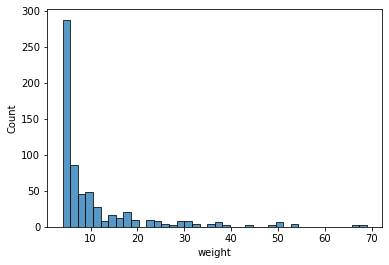

CPU times: user 255 ms, sys: 18.8 ms, total: 274 ms
Wall time: 278 ms


,source,target,weight
375,fsw,pds,4
507,tsi,pds,4
560,catharine maria sedgwick,pds,4


In [28]:
%%time

# Explode list so that each list value becomes a row.
refs = df.explode('references')

# Create file-person matrix.
refs = pd.crosstab(refs['file'], refs['references'])

# Repeat with correspondence (source + target)
source = pd.crosstab(df['file'], df['source'])
target = pd.crosstab(df['file'], df['target'])

# Sum values of sources to refs or create new column with sources' values.
for col in source:
    if col in refs:
        refs[str(col)] = refs[str(col)] + source[str(col)]
    else:
        refs[str(col)] = source[str(col)]

# Repeat for targets.
for col in target:
    if col in refs:
        refs[str(col)] = refs[str(col)] + target[str(col)]
    else:
        refs[str(col)] = target[str(col)]

# Convert entry-person matrix into an adjacency matrix of persons.
refs = refs.T.dot(refs)

# # Change diagonal values to zero. That is, a person cannot co-occur with themself.
# np.fill_diagonal(refs.values, 0)

# Create new 'source' column that corresponds to index (person).
refs['source'] = refs.index

# # Reshape dataframe to focus on source, target, and weight.
# # Rename 'people' column name to 'target'.
df_graph = pd.melt(refs, id_vars = ['source'], var_name = 'target', value_name = 'weight') \
    .rename(columns = {'references':'target'}) \
    .query('(source != target) & (weight > 3)') \
    .query('(source != "u") & (target != "u")')

# Remove rows with empty source or target.
df_graph['source'].replace('', np.nan, inplace=True)
df_graph['target'].replace('', np.nan, inplace=True)
df_graph.dropna(subset=['source', 'target'], inplace=True)



# Chart distribution of weights.
sns.histplot(data = df_graph, x = 'weight')

plt.show()

df_graph.head(3)


## Build Graph Object

In [29]:
%%time

# Initialize graph object.
G = nx.from_pandas_edgelist(df_graph, 'source', 'target', 'weight')

# Add nodes.
nodes = list( dict.fromkeys( df_graph['source'].values.tolist() + df_graph['target'].values.tolist() ))
nodes = pd.DataFrame(nodes, columns = ['source'])
G.add_nodes_from(nodes)

print (nx.info(G))

# Set degree attributes.
nx.set_node_attributes(G, dict(G.degree(G.nodes())), 'degree')

# Sort nodes by degree and print top results.
sorted_degree = sorted(dict(G.degree(G.nodes())).items(),
                       key = itemgetter(1), reverse = True)

print ("Top 10 nodes by degree:")
for d in sorted_degree[:10]:
    print (f'\t{d}')

# Measure network density.
density = nx.density(G)
print (f"Network density: {density:.3f}")

# Related to diameter, check if network is connected and, therefore, can have a diameter.
print (f"Is the network connected? {nx.is_connected(G)}")

# Find triadic closure (similar to density).
triadic_closure = nx.transitivity(G)
print (f"Triadic closure: {triadic_closure:.3f}\n")


# Get a list of network components (communities).
# Find the largest component.
components = nx.connected_components(G)
largest_component = max(components, key = len)

# Create a subgraph of the largest component and measure its diameter.
subgraph = G.subgraph(largest_component)
diameter = nx.diameter(subgraph)
print (f"Network diameter of the largest component: {diameter:.3f}")

# Find centrality measures. 
betweenness_dict = nx.betweenness_centrality(subgraph) # Run betweenness centrality
eigenvector_dict = nx.eigenvector_centrality(subgraph) # Run eigenvector centrality
degree_cent_dict = nx.degree_centrality(subgraph)

# Assign each centrality measure to an attribute.
nx.set_node_attributes(subgraph, betweenness_dict, 'betweenness')
nx.set_node_attributes(subgraph, eigenvector_dict, 'eigenvector')
nx.set_node_attributes(subgraph, degree_cent_dict, 'degree_cent')

# Find communities.
communities = community.naive_greedy_modularity_communities(subgraph)
# communities = community.k_clique_communities(subgraph, 5)
# communities = community.greedy_modularity_communities(subgraph)
# communities = community.kernighan_lin_bisection(subgraph)

# Create a dictionary that maps nodes to their community.
modularity_dict = {}
for i, c in enumerate(communities):
    for name in c:
        modularity_dict[name] = i
        
# Add modularity information to graph object.
nx.set_node_attributes(subgraph, modularity_dict, 'modularity')

Name: 
Type: Graph
Number of nodes: 65
Number of edges: 318
Average degree:   9.7846
Top 10 nodes by degree:
	('catharine maria sedgwick', 57)
	('fsw', 38)
	('hds', 34)
	('rsi', 34)
	('tsi', 28)
	('csi', 28)
	('ewi', 27)
	('srs', 24)
	('esp', 22)
	('tsii', 20)
Network density: 0.153
Is the network connected? False
Triadic closure: 0.471

Network diameter of the largest component: 3.000
CPU times: user 1min 42s, sys: 369 ms, total: 1min 43s
Wall time: 1min 44s


## Write Graph Object

In [30]:
%%time

# Convert graph object into a dictionary.
data = json_graph.node_link_data(G)

# # Serialize dictionary with json.
# class NPEncoder(JSONEncoder):
#     def default(self, obj):
#         if isinstance(obj, np.ndarray):
#             return obj.tolist()
#         return JSONEncoder.default(self, obj)
    
data_json = json.dumps(data) # , cls=NPEncoder

with open(abs_dir + "GitHub/dsg-mhs/lab_space/projects/sedgwick/coref/data/Sedgwick_coRef-network.json", "w") as f:
    f.write(data_json)

CPU times: user 1.52 ms, sys: 878 µs, total: 2.4 ms
Wall time: 1.71 ms
